## Описание проекта

Такси-стартап «Городская мобильность» получил исторические данные о вызовах такси в аэропортах. Чтобы иметь возможность привлечь больше водителей в часы-пик, необходимо предсказать количество заказов такси на следующий час. Нам следует построить модель для такого предсказания.

По условию задачи, значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# 1. Подготовка

Импортируем требуемые нам библиотеки и инструменты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

Загрузим файл и сразу установим первый столбец в качестве индекса.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=True)
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Из информации о данных мы видим, что рассматриваемый период охватыает период с начала марта по конец августа 2018 года - то есть полную весну и лето.

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


У нас есть дата через каждые 10 минут в качестве индекса и единственный столбец с целевым признаком количества заказов.

Проверим, в хронологическом ли порядке расположены значения индекса.

In [4]:
data.index.is_monotonic

True

Все верно.

Затем проведем ресемлпирование, просуммируем значения по часу.

In [5]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Итак, это наш исходный датасет, который мы будем использовать для обучения.

# 2. Анализ

Для анализа данных создадим копию.

In [6]:
data_copy = data.copy()

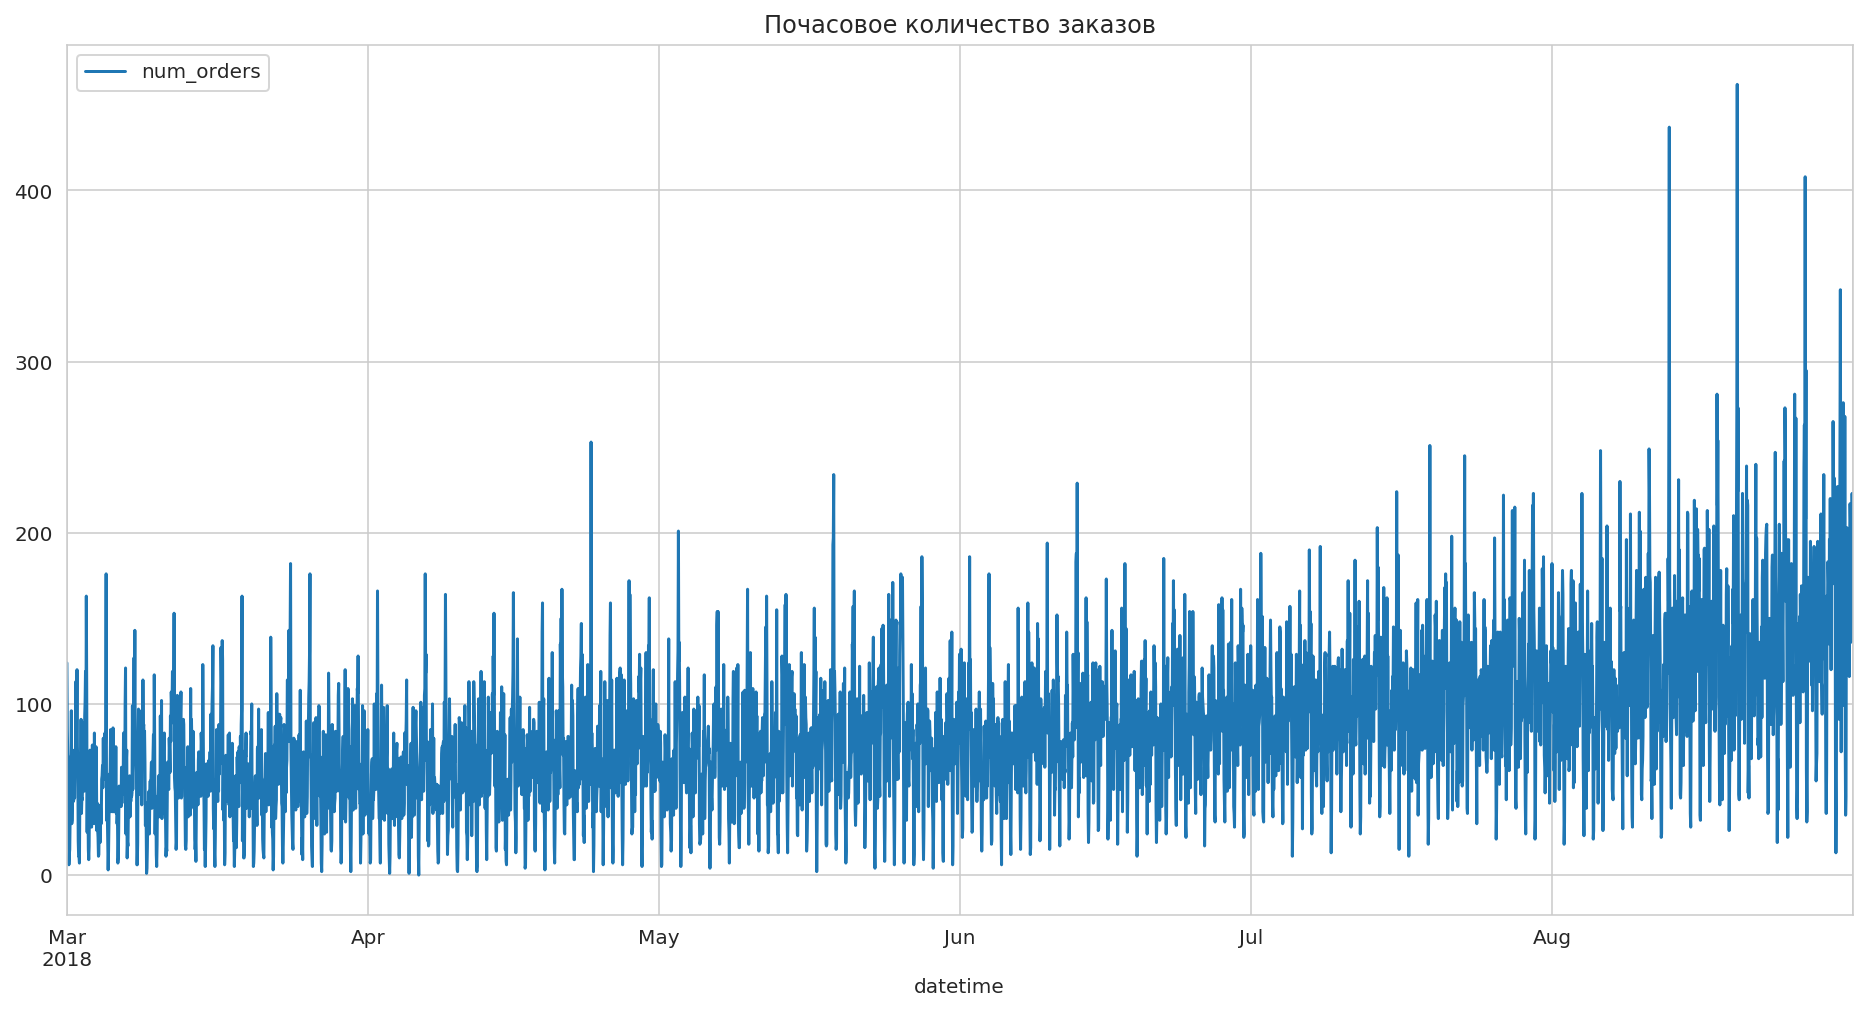

In [7]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
data_copy.plot(title='Почасовое количество заказов', figsize=(16, 8));

При таком масштабе график не очень явный, но в целом заметно, что к концу лета количество заказов в час увеличилось.

Попробуем ресмлировать и взглянуть на дневные значения.

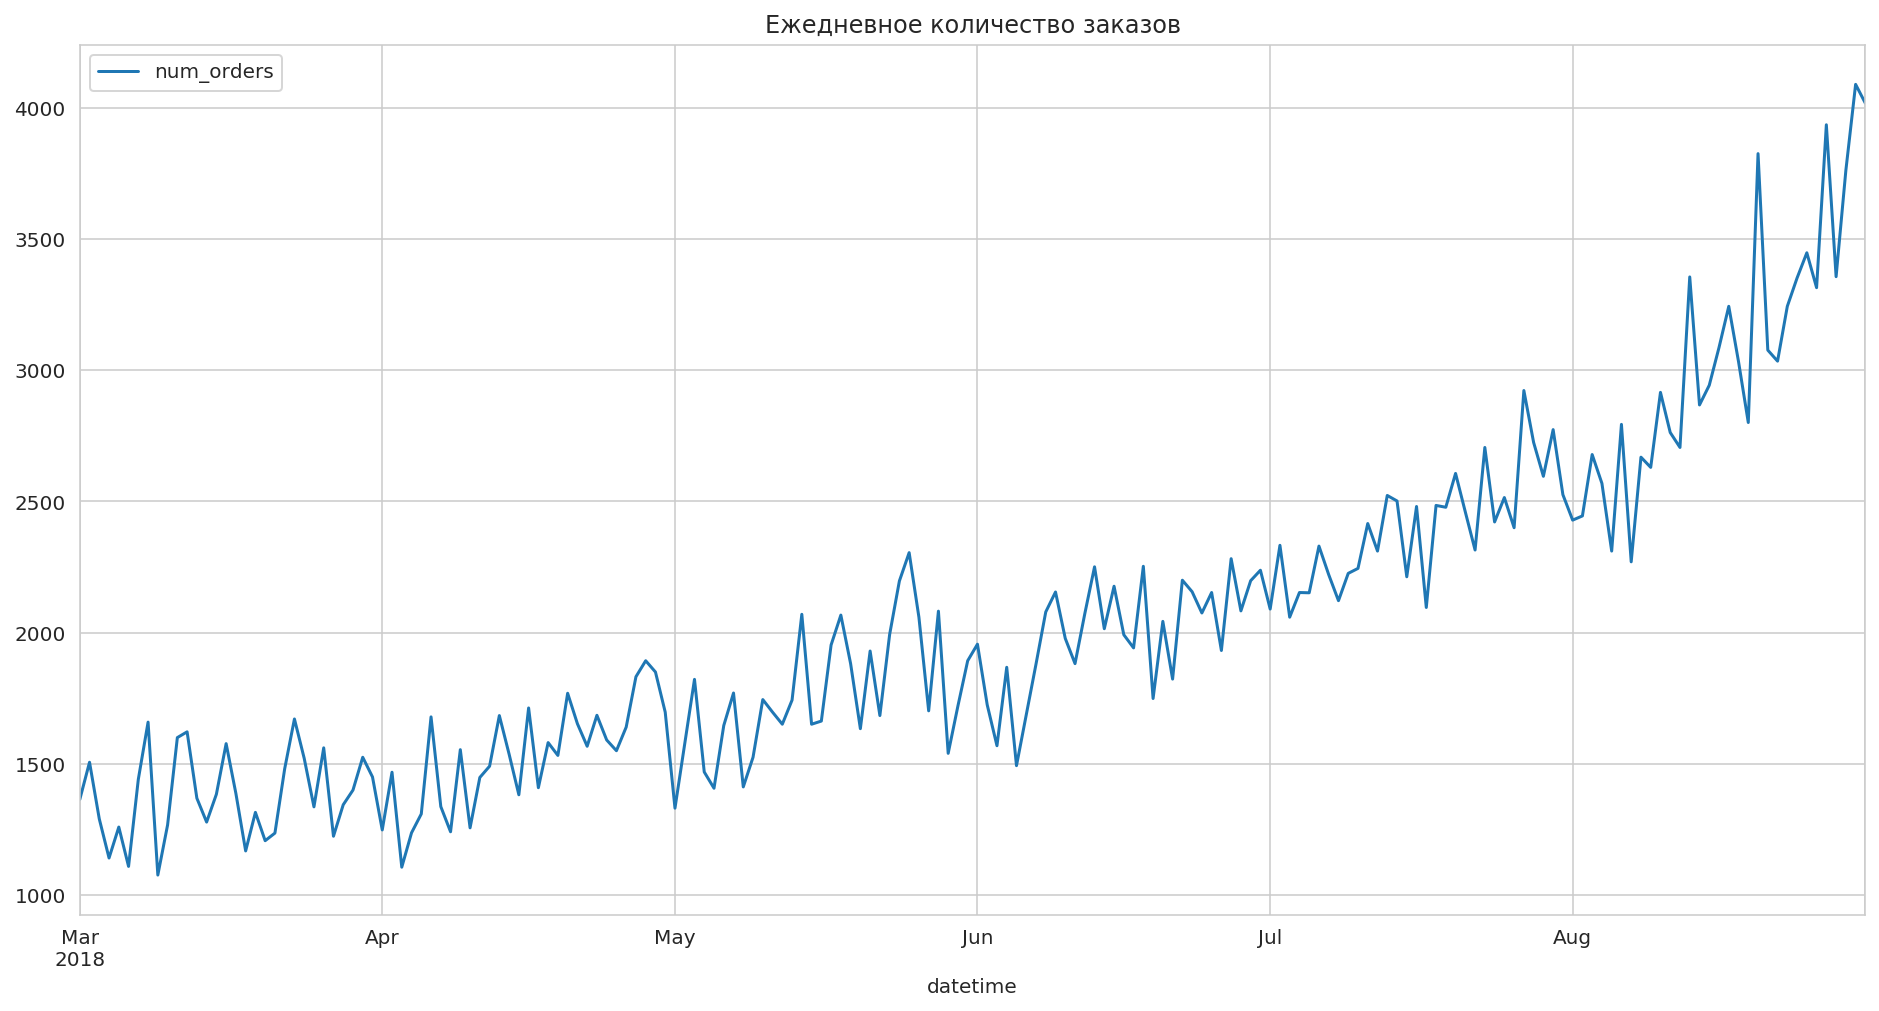

In [8]:
data_daily = data_copy.resample('1D').sum()
data_daily.plot(title='Ежедневное количество заказов', figsize=(16, 8));

Если рассмотреть дневные данные, то видно, что с апреля начался скромный рост заказов, а с июля этот рост начал ускоряться.

Попробуем добавить двухнедельную скользящую среднюю.

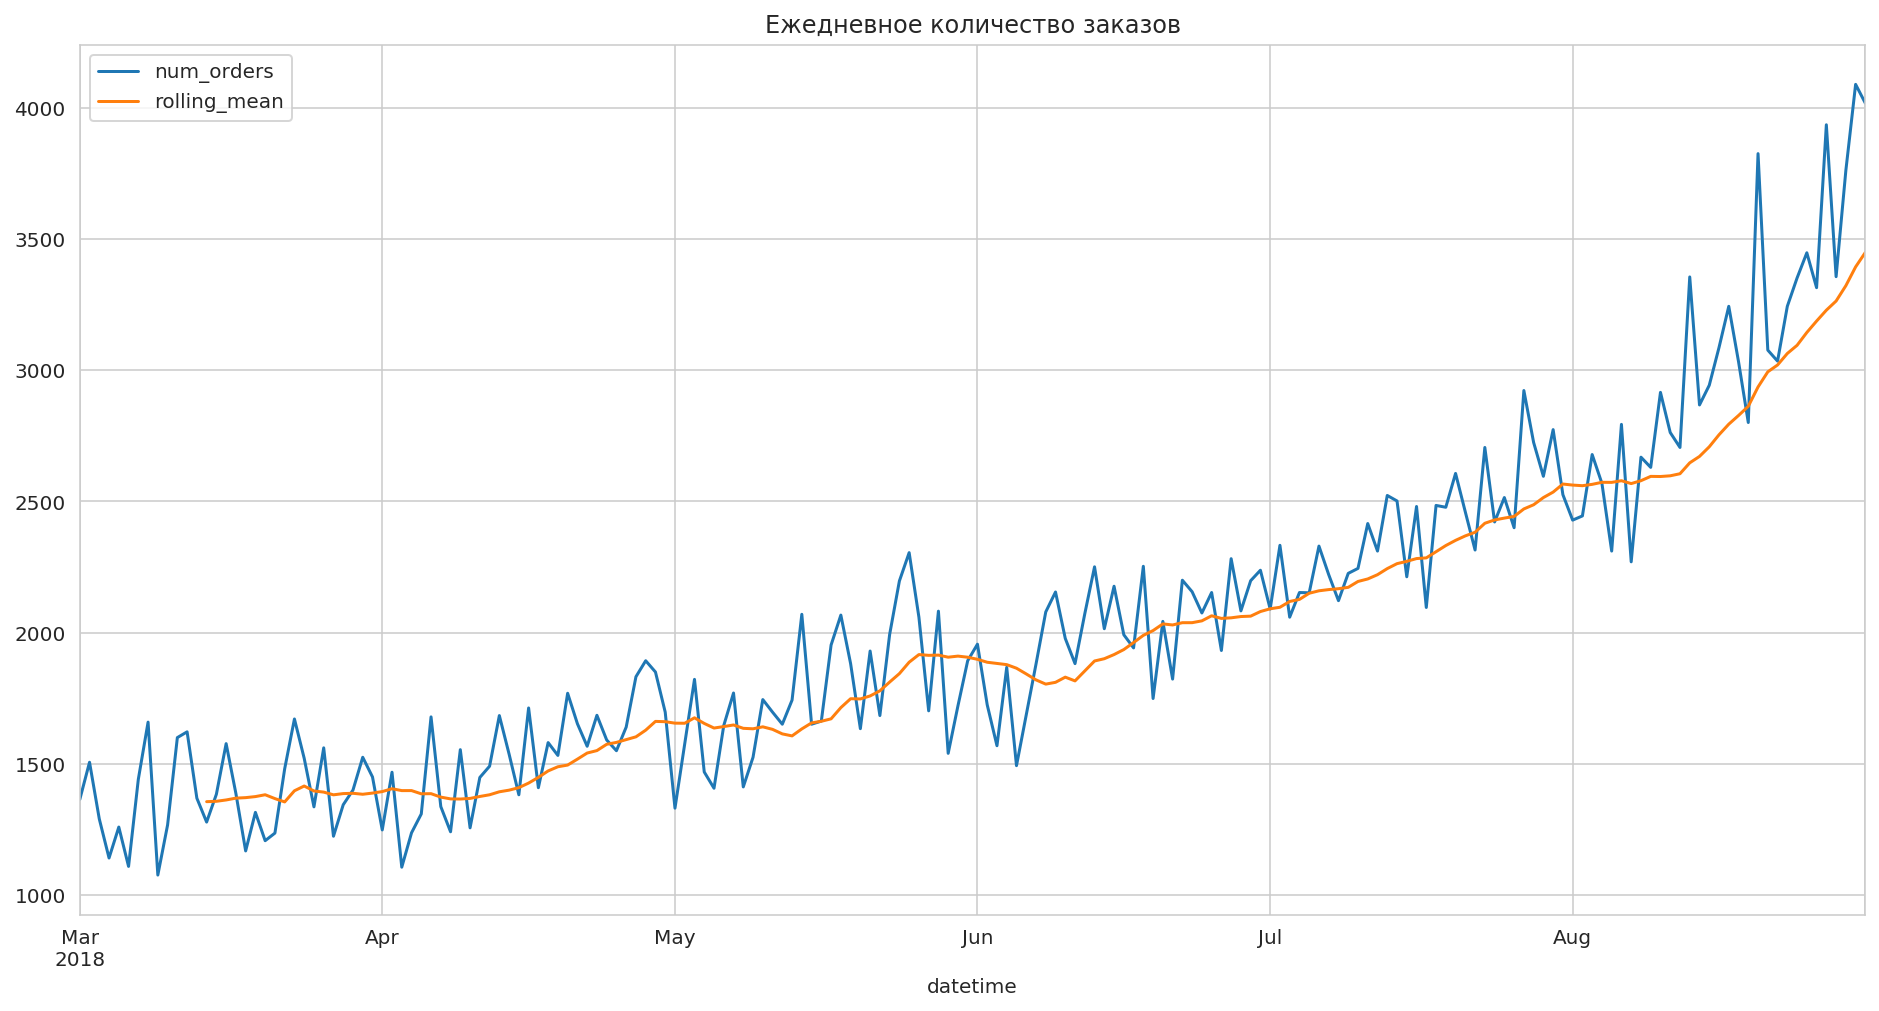

In [9]:
data_daily['rolling_mean'] = data_daily.rolling(14).mean()
data_daily.plot(title='Ежедневное количество заказов', figsize=(16, 8));

Особенно стремительным рост стал в августе.

Далее разложим наш временной ряд на составляющие.

In [10]:
decomposed = seasonal_decompose(data)

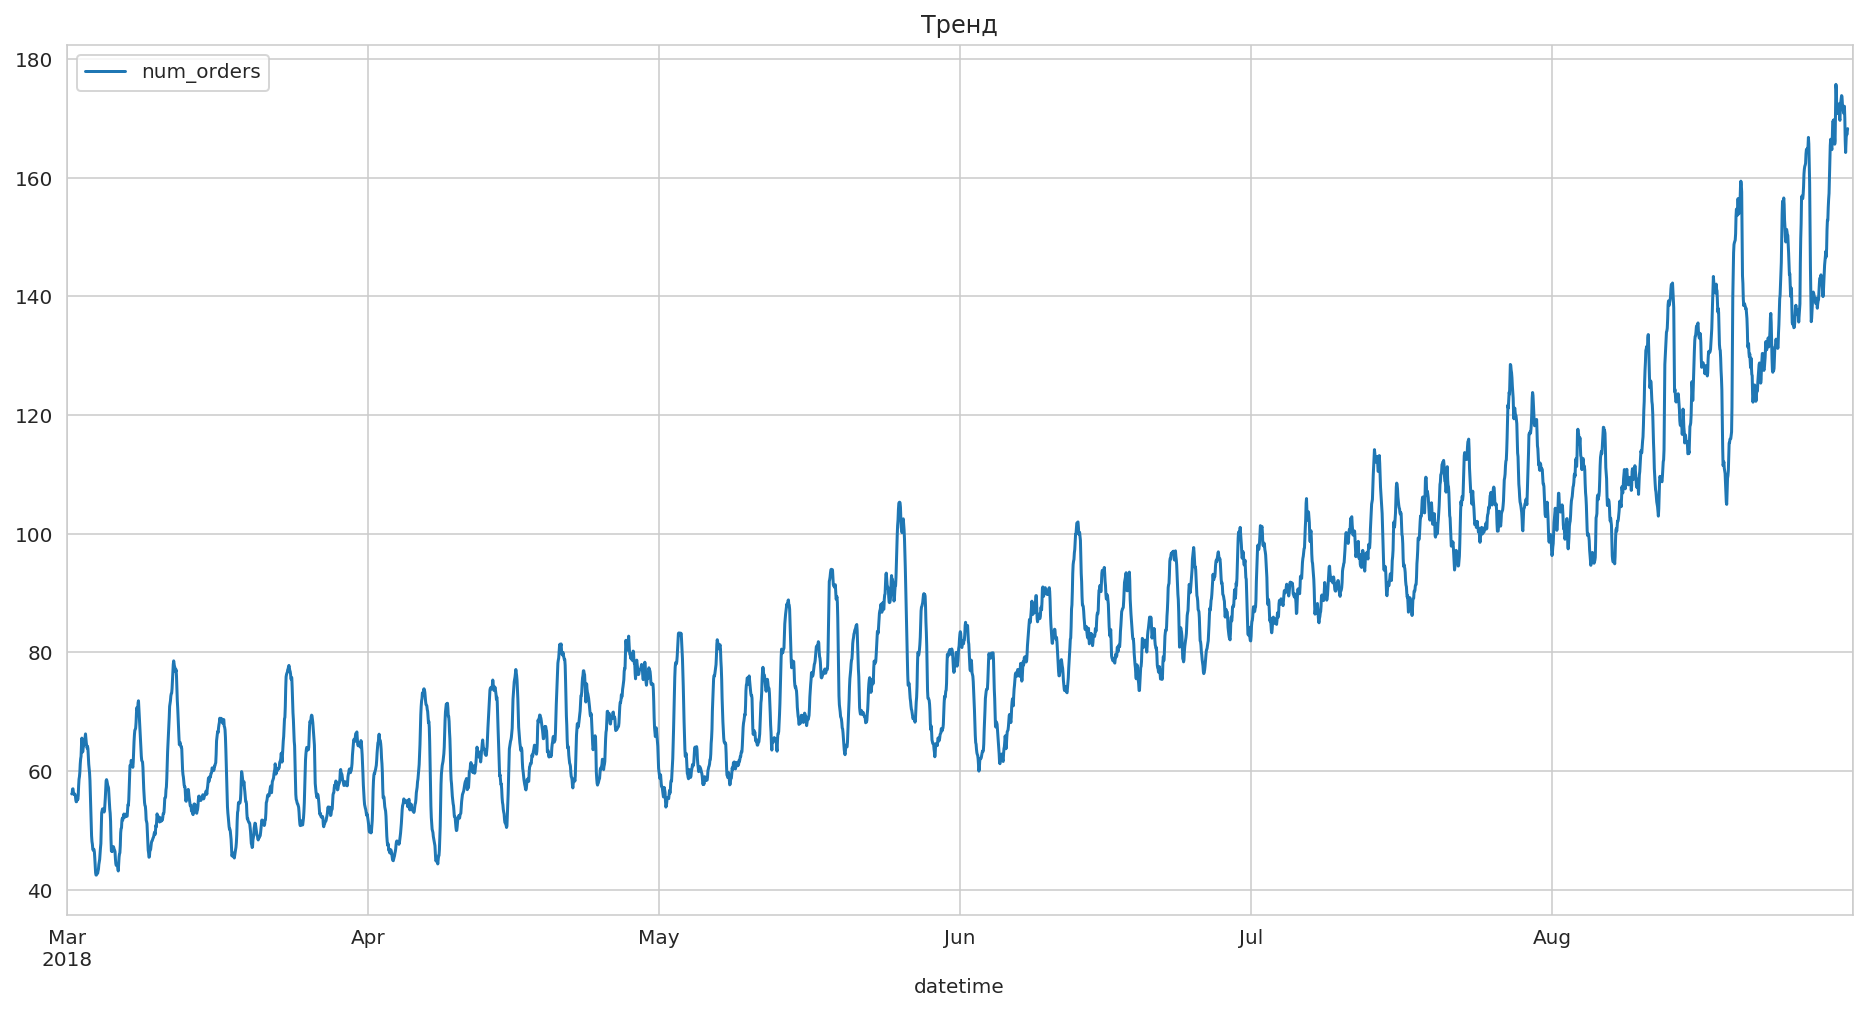

In [11]:
decomposed.trend.plot(title='Тренд', figsize=(16, 8));

Мы видим тренд с апреля по май, потом небольшое снижение в конце-мая и начале июня, затем снова положительный тренд до конца июля, небольшое снижение в начале августа и сильный рост в течение оставшейся части августа.

Для построения графика сезонно составляющей возьмем более короткий отрезок - последнюю неделю августа.

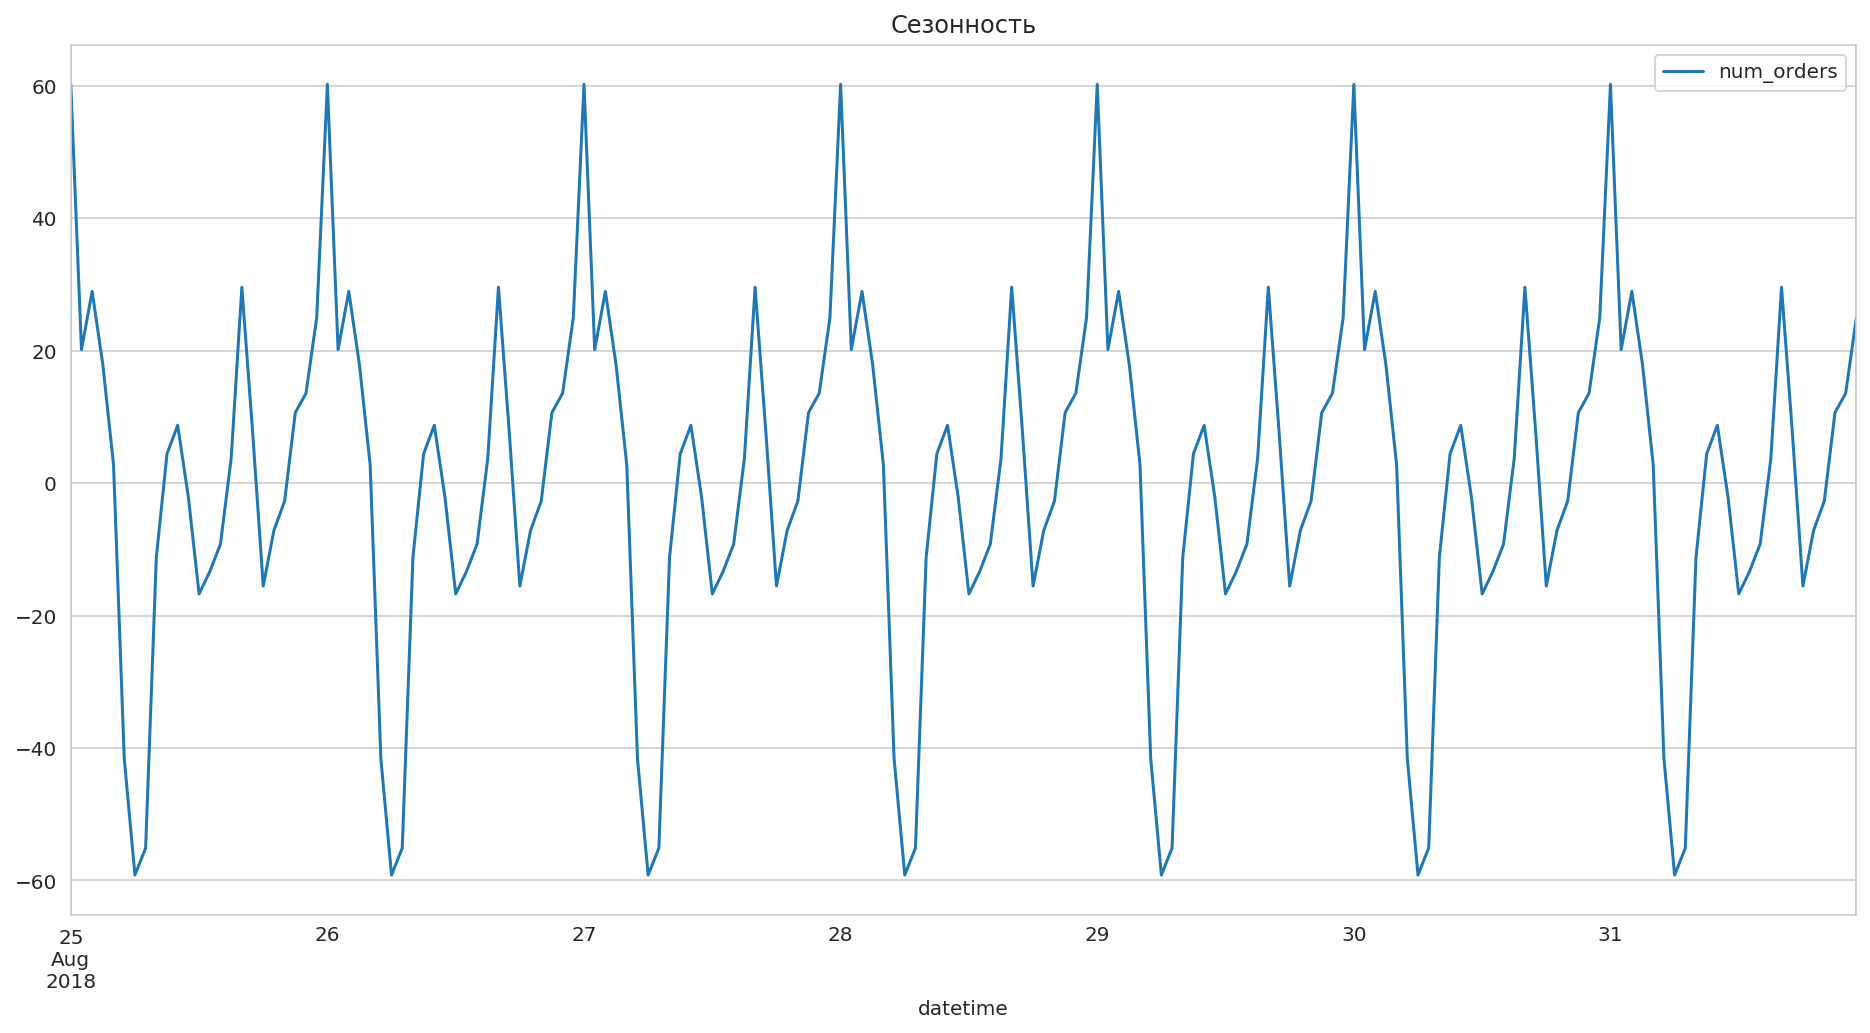

In [12]:
decomposed.seasonal.tail(24*7).plot(title='Сезонность', figsize=(16, 8));

Из графика вроде бы заметно, что спрос на такси возрастает в конце дня, а затем падает в ранние утреннние часы.

Взглянем на график остатков.

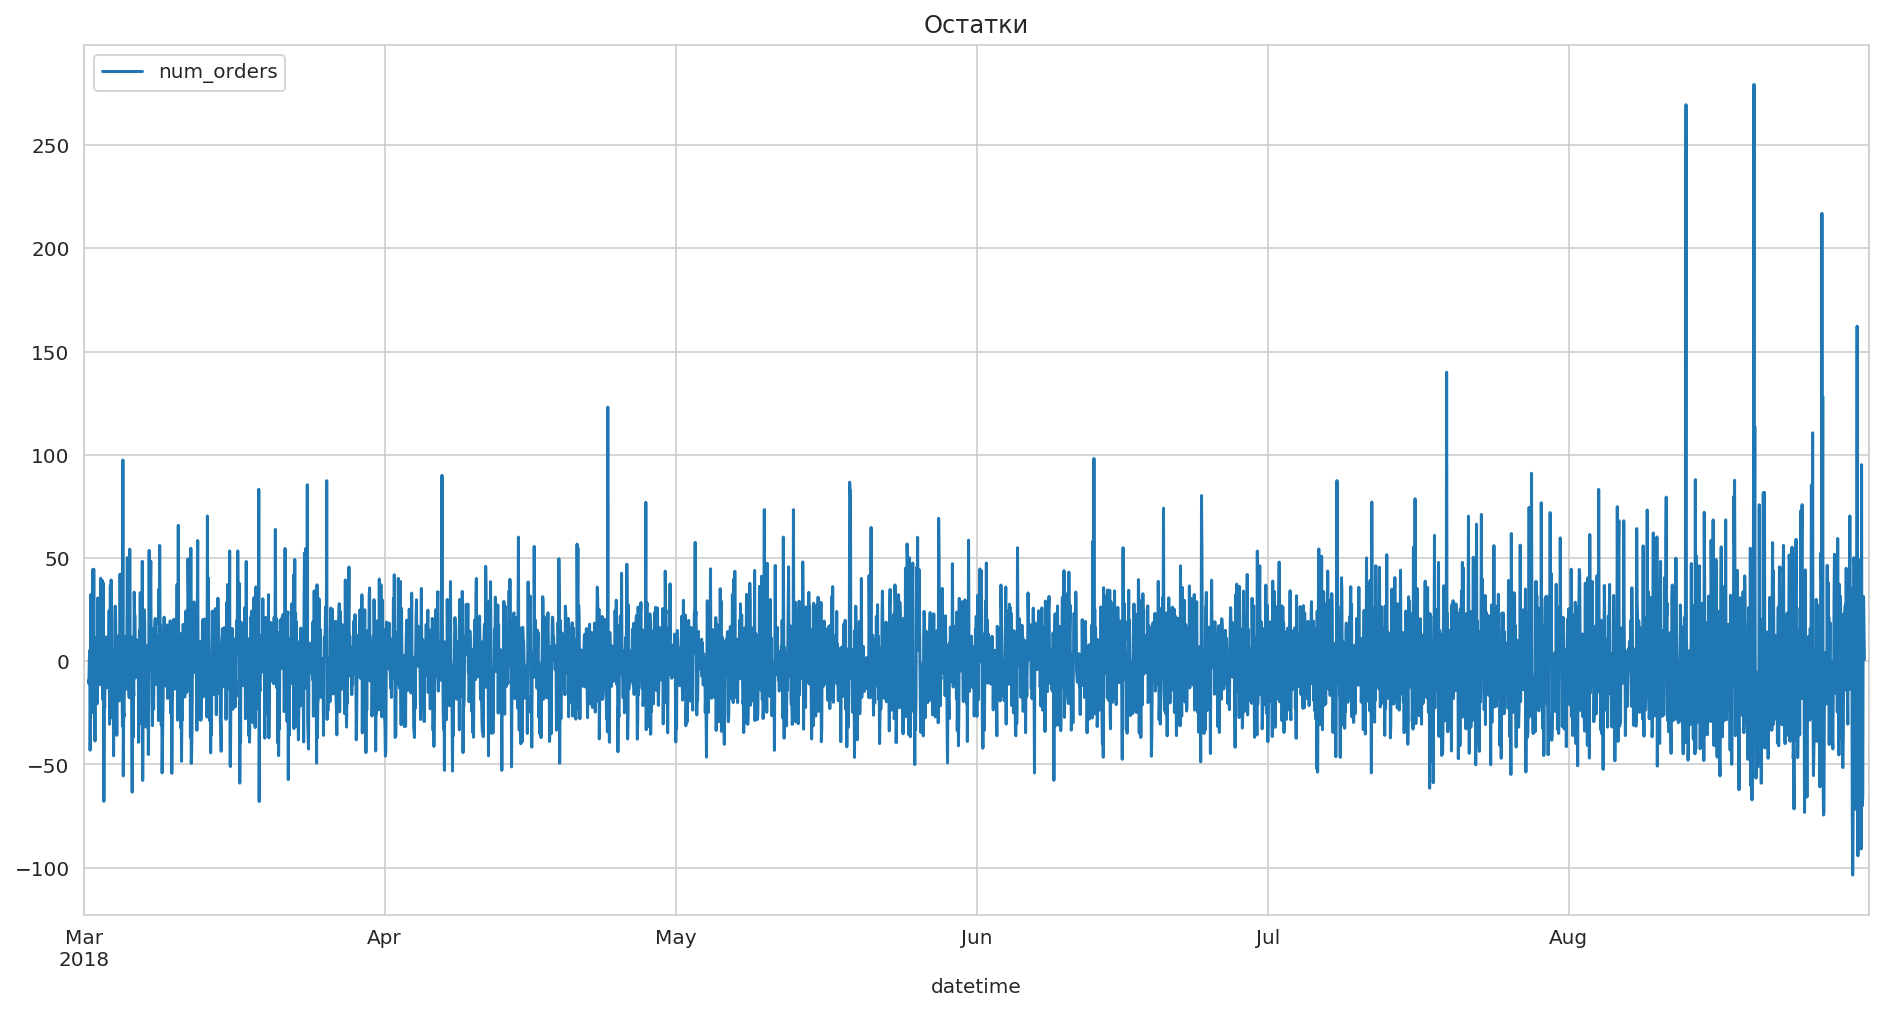

In [13]:
decomposed.resid.plot(title='Остатки', figsize=(16, 8));

Затем посчитаем разности временного ряда, вычислим скользящее среднее за 24 часа, а также скользящее стандартное отклонение.

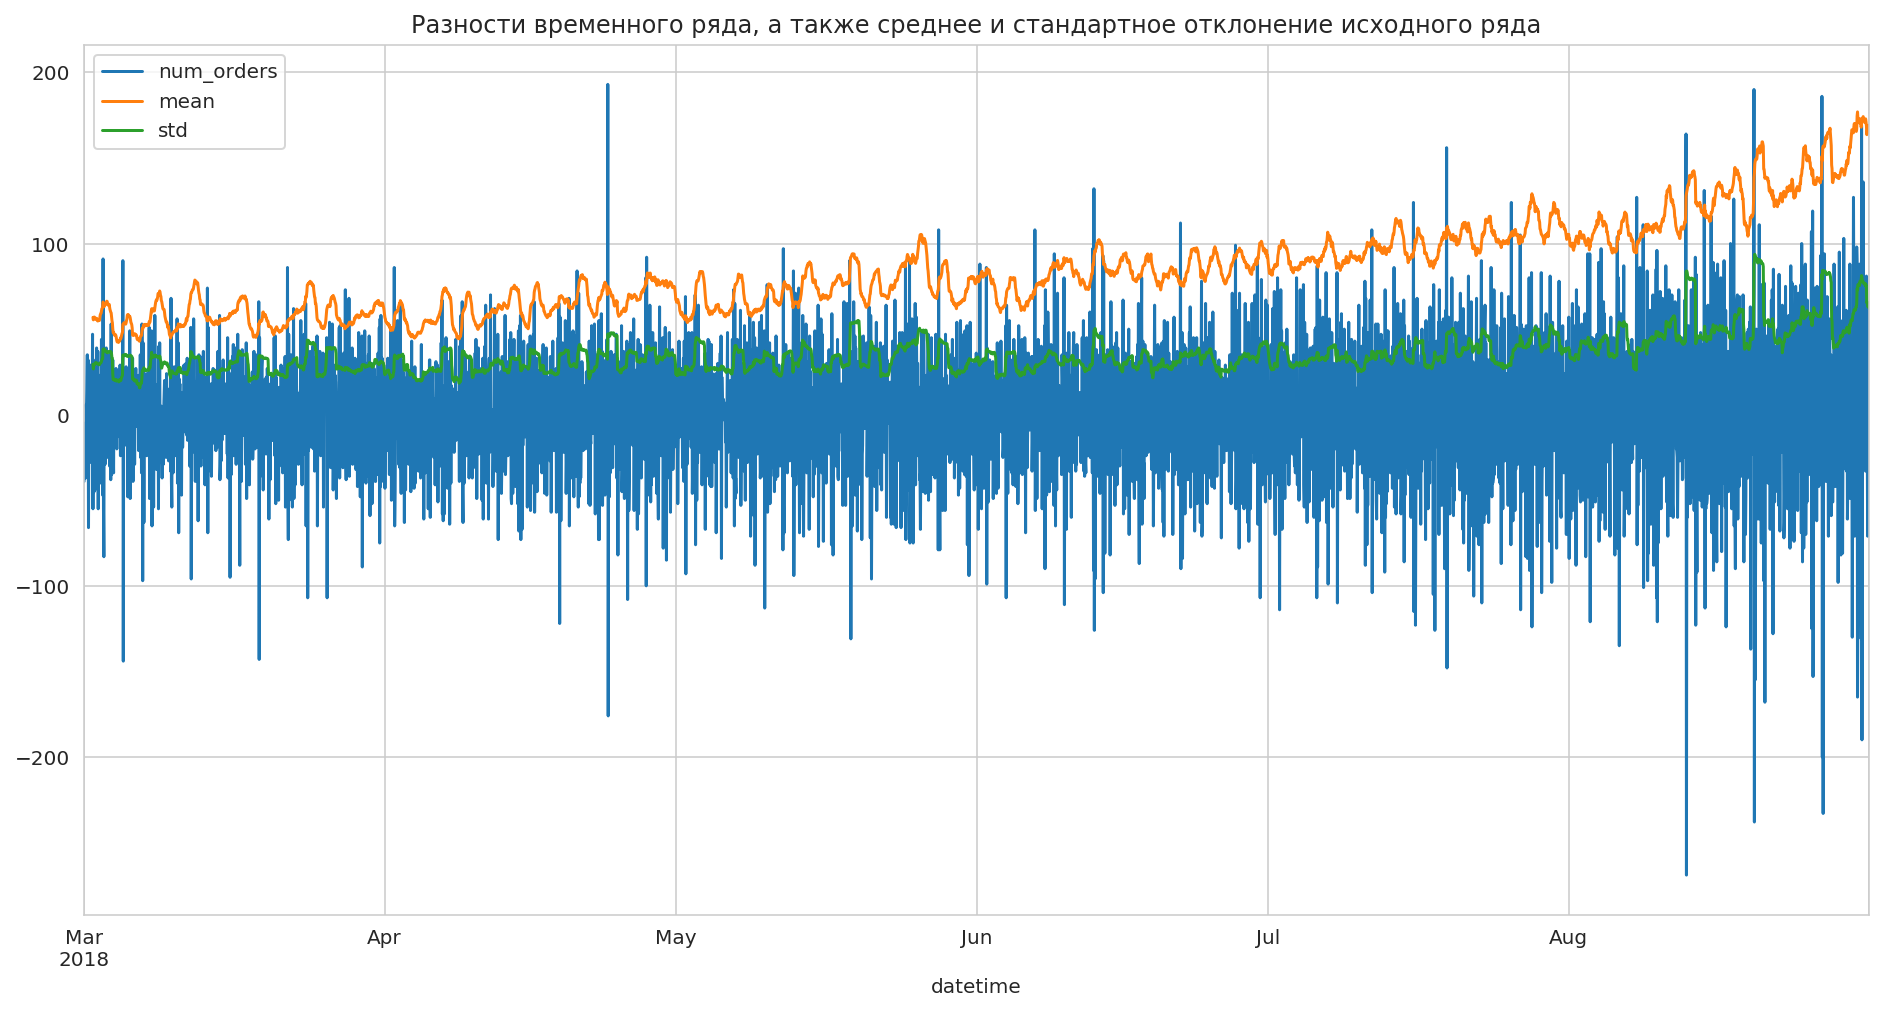

In [14]:
data_shift = data - data.shift()
data_shift['mean'] = data['num_orders'].rolling(24).mean()
data_shift['std'] = data['num_orders'].rolling(24).std()
data_shift.plot(title='Разности временного ряда, а также среднее и стандартное отклонение исходного ряда', figsize=(16, 8));

Поскольку нам вроде бы известны лишь визуальные способы оценить стационарность ряда, то глядя на график среднего и стандартного отклонения попробуем предположить, что ряд в целом стационарен: до второй половины августа среднее и ско значительно не менялись.

In [15]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


Далее сделаем небольшое отсупление и посмотрим, какая нагрузка на сервис была по дням недели.

Добавим столбцы с номером месяца и дня недели.

In [16]:
data_copy['month'] = data_copy.index.month
data_copy['day_of_week'] = data_copy.index.dayofweek

Сделаем сводную таблицу, чтобы посмотреть на динамику среднего количества заказов в завсимости от дня недели по месяцам.

In [17]:
data_wide = data_copy.pivot_table(index='month',columns='day_of_week', values='num_orders', aggfunc='mean')
data_wide

day_of_week,0,1,2,3,4,5,6
month,,,,,,,
3,59.968750,51.135417,55.197917,60.733333,61.291667,57.625000,54.635417
4,67.641667,55.854167,60.583333,62.208333,72.541667,66.875000,60.733333
5,81.791667,63.483333,70.650000,80.083333,78.520833,72.906250,70.052083
6,84.958333,75.479167,86.072917,81.260417,88.416667,85.550000,78.791667
7,104.333333,94.566667,99.677083,97.302083,108.156250,103.208333,94.466667
8,144.916667,120.541667,123.650000,129.133333,135.075000,123.052083,115.968750


Построим график.

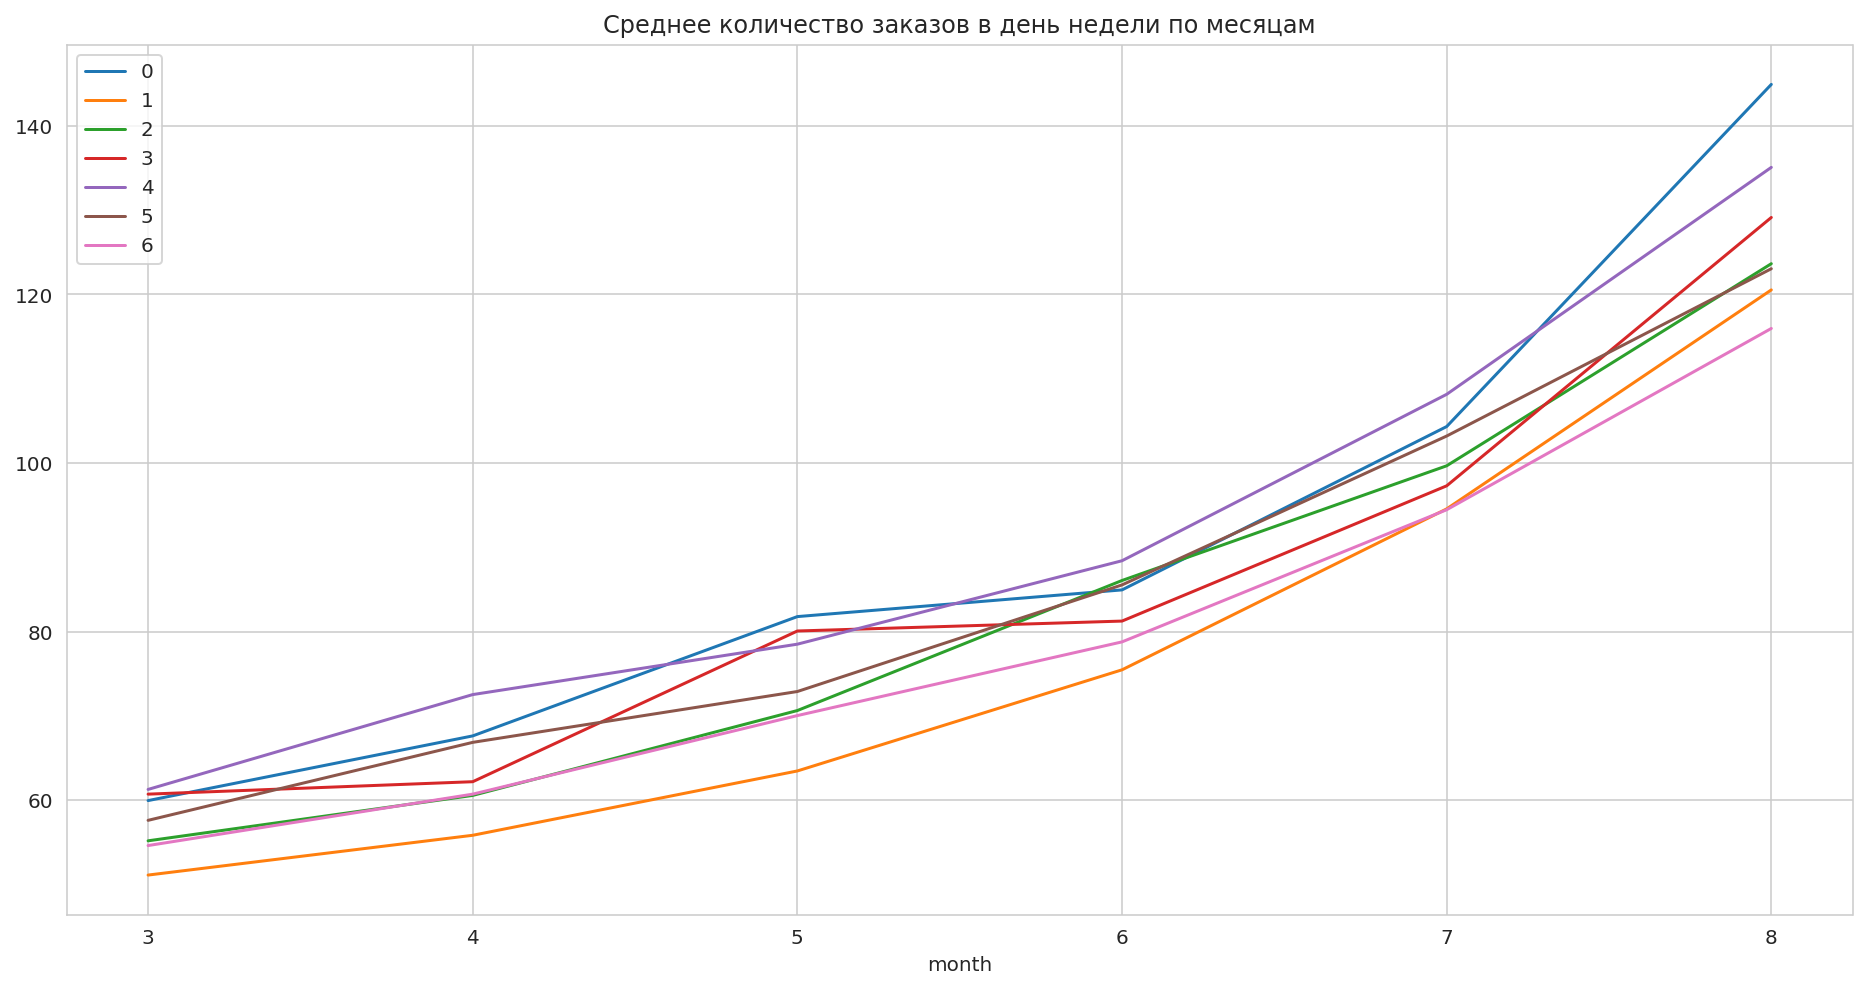

In [18]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=data_wide, dashes=False, ax=ax)
plt.title('Среднее количество заказов в день недели по месяцам');

Видно, что среднее количество заказов в день у нашего сервиса увеличилось более чем вдвое за пять месяцев.

При этом любопытно, что наиболее загруженным днем летом стал понедельник. Возможно, это связано с тем, что люди в воскресенье сидя допоздна в гостях или просто гуляя, уезжают домой на такси уже фактически в понедельник.

Так или иначе, вторым загруженным днем является пятница, затем - четверг.

# 3. Обучение и тестирование

In [19]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Создадим функцию для создания признаков. Будем создавать три типа признаков:
 - Календарные признаки - здесь создадим столбцы с днем недели и часом. Не будем создавать столбцы с месяцем и числом месяца, поскольку мы делаем прогноз на достаточно короткий промежуток и нам вроде бы необязательно знать, в каком месяце происходит дело;
 - Лаговые переменные - они помогают нам трансформировать задачу прогнозирования в задачу обучения с учителем, потому что один из способов спрогнозировать величину в периоде t+1 - это использовать предыдущие значения;
 - Скользящее среднее - как признак, задающий тренд временного ряда.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
  
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим свою функцию rmse.

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 3.1 Линейная регрессия 

Затем, для того, чтобы определить какое количество лаговых переменных добавлять, создадим цикл, который обучит для нас несколько быстрых моделей - например, моделей линейной регрессии.

In [22]:
lags = [6, 12, 24, 48, 96, 144, 192, 240, 384]

Количество лаговых переменных подобрано исходя из логики - четверть дня, полдня и так далее. Попробуем добавить разные количества переменных, чтобы узнать, даст ли большое количество признаков прибавку в точности.

Окно для скользящего среднего выберем равным 48 часам.

Далее в цикле пройдемся по списку с возможным количеством лаговых переменных. Будем вызывать функцию make_features, делить данные на обучающую, валидационную и тестовую выборки в соотношении 80% : 10% : 10% и проверять обученную модель на валидационной выборке.

In [23]:
%%time

df_copy = data.copy()

best_lin_reg_result = 20000
best_lag = 0

for lag in lags:
    
    make_features(df_copy, lag, 48)
    
    train, valid_test = train_test_split(df_copy, test_size=0.2, shuffle=False)

    valid, test = train_test_split(valid_test, test_size=0.5, shuffle=False)
    
    train = train.dropna()
    
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']

    features_valid = valid.drop('num_orders', axis=1)
    target_valid = valid['num_orders']
    
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    
    lin_reg = LinearRegression()
    lin_reg.fit(features_train, target_train)

    pred_valid = lin_reg.predict(features_valid)
    
    result = rmse(target_valid, pred_valid)
    
    print(f'RMSE = {result}, Количество лаговых переменных = {lag}')
    
    if result < best_lin_reg_result:
        best_lin_reg_result = result
        best_lag = lag
        best_lin_pred = pred_valid 

RMSE = 40.53880683462544, Количество лаговых переменных = 6
RMSE = 40.2023718502207, Количество лаговых переменных = 12
RMSE = 34.26160725839713, Количество лаговых переменных = 24
RMSE = 31.645067564206588, Количество лаговых переменных = 48
RMSE = 29.96919958925635, Количество лаговых переменных = 96
RMSE = 29.265357327936535, Количество лаговых переменных = 144
RMSE = 28.093421840603842, Количество лаговых переменных = 192
RMSE = 28.172098645884937, Количество лаговых переменных = 240
RMSE = 27.921379088604386, Количество лаговых переменных = 384
CPU times: user 2.88 s, sys: 1.64 s, total: 4.52 s
Wall time: 4.5 s


Итак, мы видим, что добавление большого количества лаговых переменных дало существенную прибавку в точности, однако после 48 переменных точность стала расти медленно. Попытаемся соблюсти баланс между точностью и скоростью обучения последующих моделей и остановимся на 192 лаговых переменных. В конце концов разница между 48 и 192 - около 3.5 заказов - а это потенциальные, минимум, 3.5 человека, успевшие, например, в аэропорт. 

192 лаговых переменных будем использовать для обучения других моделей.

In [24]:
make_features(data, 192, 48)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим линейную регрессию и проверим ее на тестовой выборке.

In [25]:
lin_reg = LinearRegression()

lin_reg.fit(features_train, target_train)

pred_test = lin_reg.predict(features_test)

lin_reg_result = rmse(target_test, pred_test)
print(f'RMSE линейной регрессии на тестовой выборке: {lin_reg_result:.3}')

RMSE линейной регрессии на тестовой выборке: 34.2


Видим, что значение RMSE на тестовой выборке составило около 34 заказов, что означает, что нам удалось существенно превзойти требуемый результат в 48 заказов.

Здесь же для проверки на адекватность спрогнозируем будущее средним и последним известным значением.

In [26]:
pred_mean = np.ones(target_test.shape) * train['num_orders'].mean() 
mean_result = rmse(target_test, pred_mean)
print("RMSE при прогнозировании средним:", rmse(target_test, pred_mean))

RMSE при прогнозировании средним: 83.9328966743385


In [27]:
pred_previous = target_test.shift(fill_value=train['num_orders'].iloc[-1]) 
previous_result = rmse(target_test, pred_previous)
print("RMSE при прогнозировании последним известным значением:", rmse(target_test, pred_previous))

RMSE при прогнозировании последним известным значением: 58.856486242815066


Итак, для того, чтобы быть адекватными, нашим моделям необходимо превосходить 59 по метрике RMSE.

## 3.2 Случайный лес 

Далее попробуем обучить случайный лес.

In [28]:
rf_model = RandomForestRegressor(random_state=2)

Будем использовать GridSearch при подборе параметров, но поскольку мы не можем просто так осуществлять кросс-валидацию на временных рядах, воспользуемся инструментом TimeSeriesSplit, который позволит нам корректно осуществить кросс-валидацию.

In [29]:
cv = TimeSeriesSplit(n_splits=2)

Очертим границы гиперпараметров.

In [30]:
forest_params = {'n_estimators': [10,20],
                'max_features' : range(2, len(features_train.columns) + 1,50),
                'max_depth': range(10,21,5),
                'min_samples_split' : range(5,15,2)}
                

forest_grid = GridSearchCV(rf_model, forest_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=True)

In [31]:
%%time
forest_grid.fit(features_train, target_train)

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.9min finished


CPU times: user 3min 55s, sys: 0 ns, total: 3min 55s
Wall time: 3min 58s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
 

In [32]:
forest_grid.best_params_

{'max_depth': 15,
 'max_features': 102,
 'min_samples_split': 13,
 'n_estimators': 20}

Таковы лучшие параметры из возможных указанных. Обучим лучшую модель и проверим на тестовой выборке.

In [33]:
test_pred_forest = forest_grid.best_estimator_.predict(features_test)
rf_result = rmse(target_test, test_pred_forest)
rf_result

38.40036485994153

Значение RMSE выше 38, что ниже нужного нам значения в 48, но выше, чем показала линейная регрессия.

## 3.3 LGBMRegressor 

Далее попробуем алгоритмы бустинга, построим модель LGBMRegressor. Среди параметров переберем несколько значений скорости обучения.

In [34]:
lgbm_reg = LGBMRegressor(random_state=2)

In [35]:
lgbm_params = {'learning_rate': [0.05, 0.07, 0.1]
                    }

lgbm_grid = GridSearchCV(lgbm_reg, lgbm_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=True)

In [36]:
lgbm_grid.fit(features_train, target_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.07, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [37]:
lgbm_grid.best_params_

{'learning_rate': 0.05}

In [38]:
lgbm_pred = lgbm_grid.best_estimator_.predict(features_test)
lgbm_result = rmse(target_test, lgbm_pred)
lgbm_result

36.471084696253904

Результат бустинга на тестовой выборке - 36.5, что лучше, чем у случайного леса, но хуже, чем у линейной регрессии.

# 4. Вывод

Сведем качество всех предсказаний в одну таблицу.

In [39]:
overall = pd.DataFrame(data=[lin_reg_result, rf_result, lgbm_result, mean_result, previous_result],
                       columns=['RMSE'],
                      index=['Линейная_регрессия', 'Случайный_лес', 'Light_GBM', 'Среднее', 'Предыдущее значение'])
overall.sort_values('RMSE')

,RMSE
Линейная_регрессия,34.150992
Light_GBM,36.471085
Случайный_лес,38.400365
Предыдущее значение,58.856486
Среднее,83.932897


Построим график для сравнения фактических данных и лучшего прогноза.

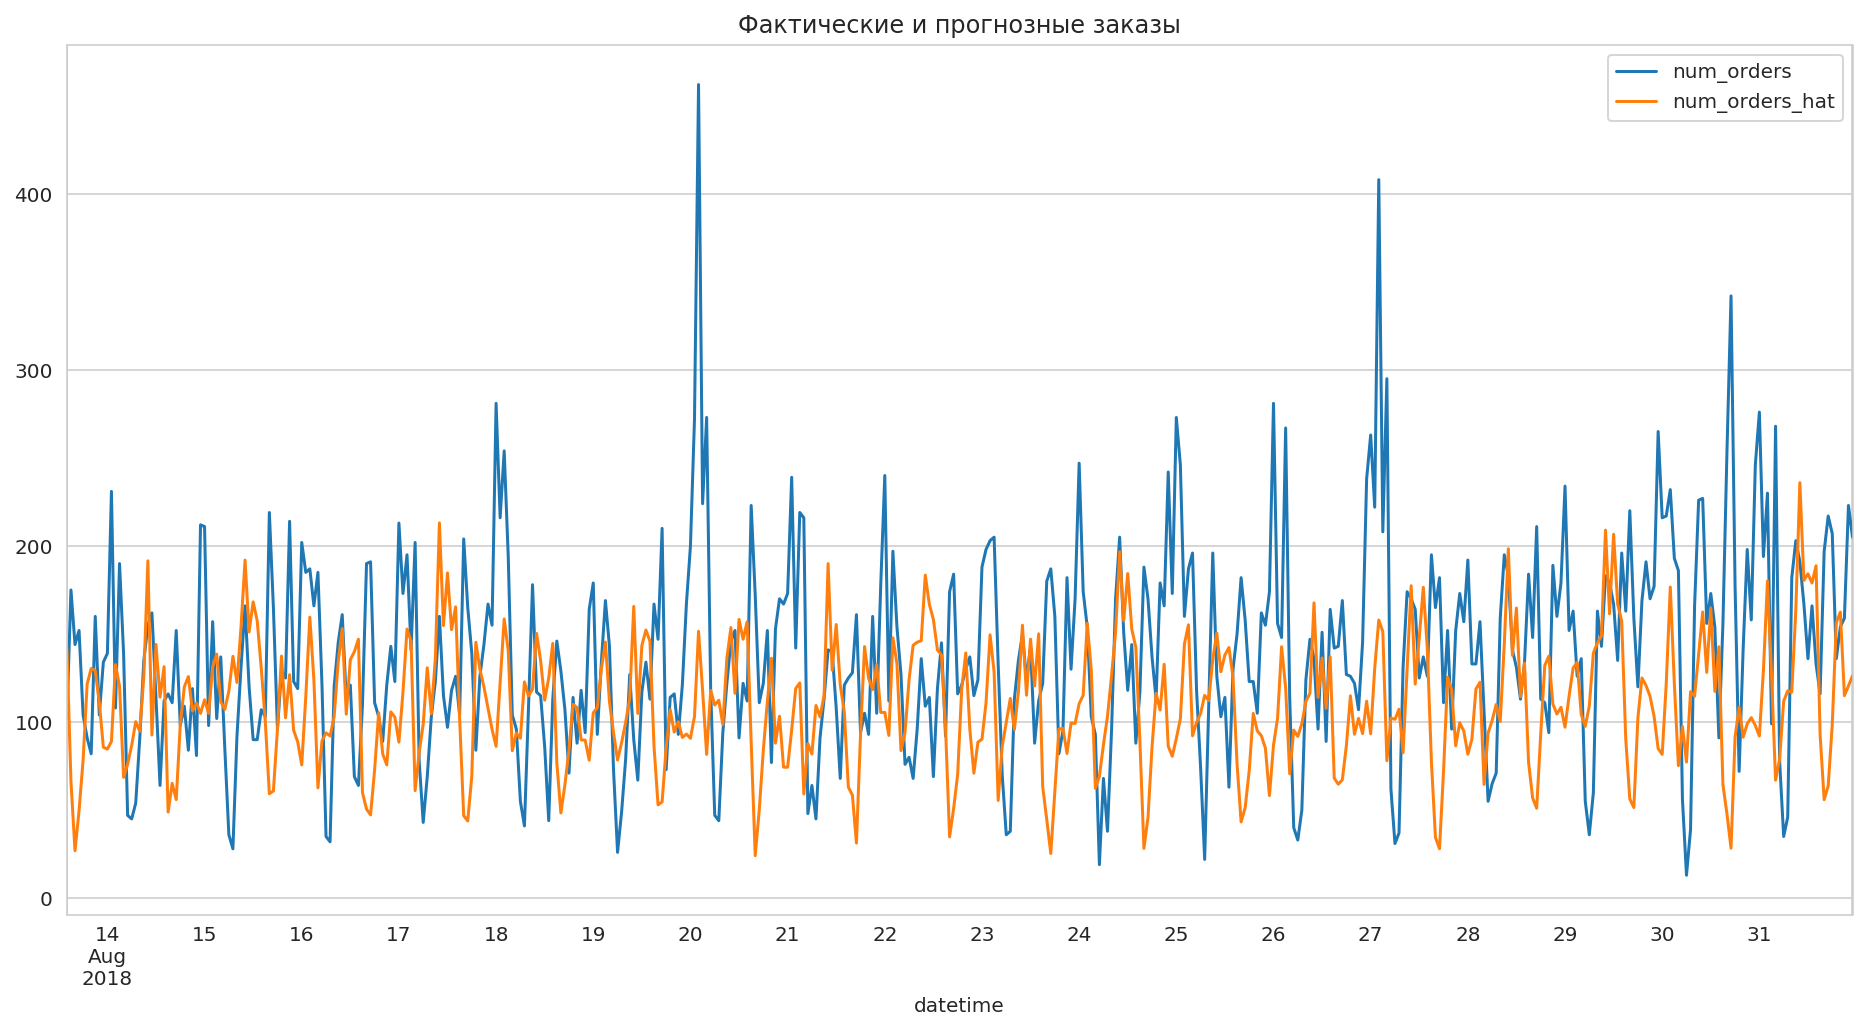

In [40]:
pd_for_plot = pd.DataFrame(data=target_test)
lin_pred = pd.DataFrame(best_lin_pred, columns=['num_orders_hat'], index=target_test.index)
pd.concat([pd_for_plot, lin_pred],axis=1 ).plot(title='Фактические и прогнозные заказы', 
                                                figsize=(16, 8));

Как мы видим, в целом отклонения лучшего прогноза не выглядят вопиющими, модель не справилась с выбросами 20, 27 и 30 августа.

Итак, линейная регрессия показала себя лучшей моделью для этой задачи прогнозирования. При этом случайным лесом и LightGBM удалось достичь результатов, существенно превосходящих требуемый порог в 48.

На наш взгляд, важным фактором в достижении таких результатов стало создание большого количества лаговых переменных - динамика обучения линейной регрессии показывала поступательное сокращение RMSE.

Визуальный анализ нашего временного ряда вроде бы позволяет считать его скорее стационарным.

Все обученные модели прошли проверку на адекватность - их качество выше прогноза среднего и предыдущего значения.